In [1]:
import os
import sys
path=!pwd
sys.path.append(os.path.join(path[0], '..'))
import numpy as np
import math
import pandas as pd
import re
from datetime import date, datetime, timedelta
import json
from abc import ABCMeta, abstractmethod
import boto3
# import snowflake.connector
from io import StringIO
import logging 
from scipy.optimize import curve_fit


logger = logging.getLogger()
logging.basicConfig(level=logging.INFO)
logger.info(f'Starting Notebook')

from utils import *

class Utils():
    @staticmethod
    def to_csv_s3(content, bucket, key_path, filename):
        client = boto3.client('s3')
        key = os.path.join(key_path, filename)
        csv_buffer = StringIO()
        content.to_csv(csv_buffer)
        client.put_object(Bucket=bucket, Key=key, Body=csv_buffer.getvalue())
        logger.info(f'Saved to {bucket}/{key}')
    
    @staticmethod
    def to_pkl_s3(content, bucket, key_path, filename):
        client = boto3.client('s3')
        key = os.path.join(key_path, filename)
        obj = pickle.dumps(content)
        client.put_object(Bucket=bucket, Key=key, Body=obj)
        logger.info(f'Saved model to {os.path.join(bucket, key)}')
        logger.info(f'Saved to {bucket}/{key}')

    @staticmethod
    def read_csv_s3(bucket, key_path,filename):
        client = boto3.client('s3')
        key = os.path.join(key_path, filename)
        obj = client.get_object(Bucket=bucket, Key=key)
        df = pd.read_csv(obj['Body'], na_values="\\N")
        logger.info(f'Read from {bucket}/{key}')
        return df
        
    @staticmethod
    def read_pkl_s3(bucket, key_path,filename):
        client = boto3.client('s3')
        key = os.path.join(key_path, filename)
        obj = client.get_object(Bucket=bucket, Key=key)
        body = obj['Body'].read()
        model = pickle.loads(body)
        logger.info(f'Read from {bucket}/{key}')
        return model    

class Credentials(metaclass=ABCMeta):
    pass
    
    
class SSMPSCredentials(Credentials):
    def __init__(self, secretid: str):
        self._secretid = secretid
        self._secrets = {}
        
    def get_keys(self):
        """
        credential fetching 
        """
        _aws_sm_args = {'service_name': 'secretsmanager', 'region_name': 'us-east-1'}
        secrets_client = boto3.client(**_aws_sm_args)
        get_secret_value_response = secrets_client.get_secret_value(SecretId=self._secretid)
        return get_secret_value_response
    
    
class BaseConnector(metaclass=ABCMeta):
    @abstractmethod
    def connect(self):
        raise NotImplementedError

        
class SnowflakeConnector(BaseConnector):
    def __init__(self, credentials: Credentials):
        keys = credentials.get_keys()
        self._secrets = json.loads(keys.get('SecretString', "{}"))

    def connect(self, dbname: str, schema: str = 'DEFAULT'):
        ctx = snowflake.connector.connect(
            user=self._secrets['login_name'],
            password=self._secrets['login_password'],
            account=self._secrets['account'],
            warehouse=self._secrets['warehouse'],
            database=dbname,
            schema=schema
        )
        return ctx

    
def run_query(querystr, ctx):
    cursor_list = ctx.execute_string(
        querystr
        )
    df = pd.DataFrame.from_records(cursor_list[-1].fetchall(), columns=[x[0] for x in cursor_list[-1].description])
    df.columns= df.columns.str.lower()
    return df

import plotly.express as px
def get_simple_plot(df_plt, x, y, grpby, text, title=''):
    if title=='':
        title = f'{y} vs {x}'
    df_plt[grpby] = df_plt[grpby].astype(str)
    fig = px.line(df_plt,
                  x=x, 
                  y=y, 
                  title=title,
                  color=grpby, 
                  hover_data=[text],
                  width=800, height=400)
    fig.show()
    return 


## Credentials
SF_CREDS = 'datascience-max-dev-sagemaker-notebooks'

## Snowflake connection 
# conn=SnowflakeConnector(SSMPSCredentials(SF_CREDS))
# ctx=conn.connect("MAX_PROD","DATASCIENCE_STAGE")
# cur = ctx.cursor()

input_bucket="hbo-ingest-datascience-content-dev"
output_bucket="hbo-outbound-datascience-content-dev"
key_path = 'cost_allocation/dev'

INFO:root:Starting Notebook


## SVOD Monthly, Retail,  domestic

In [6]:
# df_60_0 = Utils.read_csv_s3(input_bucket, key_path, 'churn_user_stream_full_genpop_60d_20221001_as.csv')
# df_60_1 = Utils.read_csv_s3(input_bucket, key_path, 'churn_user_stream_full_genpop_60d_20221101_as.csv')
# df_60_2 = Utils.read_csv_s3(input_bucket, key_path, 'churn_user_stream_full_genpop_60d_20221201_as.csv')

df_60 = Utils.read_csv_s3(input_bucket, key_path, 'churn_user_stream_full_genpop_60d_20221001_as.csv')

# df_60 = pd.concat([df_60_0, df_60_1, df_60_2])
df_60['tenure_months'] = df_60['sub_month']
df_60['monthly_hours_viewed'] = np.where(df_60['tenure_months']>1, df_60['hours_viewed']/2, df_60['hours_viewed'])
df_60['genre_original'] = df_60.genre
df_60['genre'] = np.where(~df_60.genre.isin(['action','comedy','drama']), 'other', df_60.genre)
df_60 = df_60[df_60.tenure_months>=2]

# df_60['monthly_titles_viewed'] = np.where(df_60['tenure_months']>1, df_60['titles_viewed']/2, df_60['titles_viewed'])
df_60 = df_60.reset_index()
df_60=df_60.fillna(0)

print(df_60.shape)
display(df_60.head())
# display(df_60.groupby(by=['segment_name']).count())

# display(df_hv.loc[1,'hbo_uuid'])
# display(df_hv[df_hv.hbo_uuid=='77ad0a1d78392ed3084d4e2e5fd52d604db4d15e04ada1ea3b25a14c4bcd0ccc'].sort_values(by='request_date'))
# display(df_ha.head())

INFO:root:Read from hbo-ingest-datascience-content-dev/cost_allocation/dev/churn_user_stream_full_genpop_60d_20221001_as.csv


(15800814, 15)


,index,Unnamed: 0,hbo_uuid,hurley_user_id,is_cancel,sub_month,program_type,content_category,genre,old_new,medal,hours_viewed,tenure_months,monthly_hours_viewed,genre_original
0,0,0,faa607e8c358840d5c32a303faefb51f7b0396129df7dc...,gKs5k+xHZl4Ej+2u5f5z+9UPBz8M14gLuOwC+sZjjUM=,False,18,acquired,series,comedy,library,0,28.190833,18,14.095417,comedy
1,1,1,c04733712d9a99b40fa4c245d18d3989c1c5f93e380cc3...,oDUyAUv81FLrU46qOWLKTt1fy4hCyCZ9WM8JY0jr8Rg=,False,10,acquired,series,drama,library,0,224.280833,10,112.140417,drama
2,2,2,32760ad88d155a9dd32483eb5d4eae72c53dc82f1dfd76...,G6xLZUS3njzF0KsLYcD5Ibjni8mjfw5pKwG00GPpOrM=,False,14,original,series,drama,current,Bronze,7.677500,14,3.838750,drama
3,3,3,4af122a6af5270dcc1c6947f517c91681674f2fb73a72f...,2FaV+lMOK8dZLECBBsdh+5wn1mCBTiere8NjMcCOG+Y=,False,18,original,series,drama,current,Silver,1.152500,18,0.576250,drama
4,4,4,0fdd4d1d4f32cea76c1287fcdf860720fb965ffb7b2c5b...,qL1QHf4yVzCd4v+D61zw3JcR6RJVfOa+dM8nd+WgbN0=,False,27,acquired,movies,comedy,library,0,8.245000,27,4.122500,comedy


In [10]:
df_hv_pred = Utils.read_csv_s3(input_bucket, key_path, f'hv_watched_v0.csv')
df_hv_decay = Utils.read_csv_s3("hbo-outbound-datascience-content-dev", "title_hours_viewed_retention", 'daily_monthly_retention_value.csv.csv')
display(df_hv_pred[['pillar_genre', 'content_category','medal','prediction']][df_hv_pred.pillar_genre.isin(['Drama','Action/Adventure ','Comedy'])].groupby(by=['content_category','pillar_genre', 'medal',]).mean())

df_title = df_hv_decay.groupby(by=['title_name','genre','medal']).sum().reset_index()
a = df_title.groupby(by=['genre','medal']).mean()
display(a)

print(df_hv_decay.shape)
df_hv_decay = df_hv_decay.merge(df_hv_pred[['title_id','content_category','season_number','prediction']], on=['title_id','season_number'], how='left')


Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
INFO:root:Read from hbo-ingest-datascience-content-dev/cost_allocation/dev/hv_watched_v0.csv
INFO:root:Read from hbo-outbound-datascience-content-dev/title_hours_viewed_retention/daily_monthly_retention_value.csv.csv


prediction
content_category pillar_genre      medal               
movies           Action/Adventure  Gold        0.146642
                                   None        0.078615
                                   Platinum    0.247435
                                   Silver      0.131998
                 Comedy            Bronze      0.055138
                                   Gold        0.126681
                                   None        0.062692
                                   Platinum    0.240829
                                   Silver      0.115035
                 Drama             Bronze      0.060550
                                   Gold        0.118185
                                   None        0.063651
                                   Platinum    0.195526
                                   Silver      0.100620
series           Comedy            Bronze      0.060328
                                   Gold        0.136388
                                   None        0.086720
                                   Platinum    0.294067
                                   Silver      0.120263
                 Drama             Bronze      0.057244
                                   Gold        0.122416
                                   None        0.067941
                                   Platinum    0.196336
                                   Silver      0.114598
special          Comedy            Bronze      0.064856
                                   None        0.087220

season_number  days_on_hbo_max  change_in_churn
genre  medal                                                    
action Bronze         0.000000    141464.385621        -0.005971
       Gold           0.000000     90100.000000        -0.032550
       Platinum       0.000000     90100.000000        -0.020990
       Silver         0.000000     90100.000000        -0.004881
comedy Bronze      1781.727273    267009.769231        -0.013627
       Gold         297.500000     90100.000000        -0.005124
       Platinum     212.500000     90100.000000        -0.003001
       Silver       701.533333     98185.200000        -0.003985
drama  Bronze      1290.633333    274244.844444        -0.004255
       Gold         413.235294     97438.235294        -0.007505
       Platinum     253.200000     89722.000000        -0.024300
       Silver       425.066667     94790.733333        -0.002583
other  Bronze       827.847222    127851.800926        -0.003261
       Gold         537.368421     99944.210526        -0.035652
       Platinum      42.500000     90100.000000        -0.067090
       Silver       286.806452     89443.580645        -0.012317

(452082, 10)


In [5]:
s=df_60[(df_60.genre.isin(['comedy','drama','action']) & (df_60.medal!=0))].groupby(by=['old_new','content_category','genre','medal']).count()
display(s)

index  Unnamed: 0  hbo_uuid  \
old_new content_category genre  medal                                     
current movies           action Bronze       2621        2621      2621   
                                Gold       854214      854214    854214   
                                Platinum  1009679     1009679   1009679   
                                Silver      61541       61541     61541   
                         comedy Bronze      33776       33776     33776   
                                Gold       500531      500531    500531   
                                Silver       5360        5360      5360   
                         drama  Bronze     160818      160818    160818   
                                Gold       628367      628367    628367   
                                Platinum   943102      943102    943102   
                                Silver     100767      100767    100767   
        series           action Bronze     377803      377803    377803   
                                Silver      60657       60657     60657   
                         comedy Bronze     308759      308759    308759   
                                Gold       214855      214855    214855   
                                Platinum   111835      111835    111835   
                                Silver     621607      621607    621607   
                         drama  Bronze     359577      359577    359577   
                                Gold      1124867     1124867   1124867   
                                Platinum  3167400     3167400   3167400   
                                Silver     217316      217316    217316   
        special          comedy Bronze      77063       77063     77063   
library movies           action Bronze      35849       35849     35849   
                                Gold       694936      694936    694936   
                                Platinum   412567      412567    412567   
                         comedy Bronze      16211       16211     16211   
                                Gold        11842       11842     11842   
                         drama  Bronze      43138       43138     43138   
                                Gold       136839      136839    136839   
                                Platinum    22219       22219     22219   
                                Silver      47003       47003     47003   
        series           action Bronze      35044       35044     35044   
                                Silver      61409       61409     61409   
                         comedy Bronze      30285       30285     30285   
                                Gold         7265        7265      7265   
                                Platinum    33752       33752     33752   
                                Silver      62700       62700     62700   
                         drama  Bronze      40661       40661     40661   
                                Gold       679359      679359    679359   
                                Platinum    14427       14427     14427   
                                Silver     165689      165689    165689   
        special          comedy Bronze      11232       11232     11232   
                                Platinum    28166       28166     28166   
                         drama  Gold         1373        1373      1373   
                                Silver       7405        7405      7405   

                                          hurley_user_id  is_cancel  \
old_new content_category genre  medal                                 
current movies           action Bronze              2621       2621   
                                Gold              854214     854214   
                                Platinum         1009679    1009679   
                                Silver             61541      61541   
                         comedy Bronze             33776      33776   
                     

## Medal- genre curve, fitting multiple curves 

In [39]:
def get_simple_plot_multiple(df_plt, x, y, x_fit, y_fit, params, title=''):
    if title=='':
        
        title = f'{y} vs {x}'
       
    a_fit, b_fit, c_fit = params
    annotation_x_loc = 50
    annotation_y_loc = y_fit.min() +(y_fit.max()  - y_fit.min() )/2 
        
    fig = px.scatter(df_plt,
                  x=x, 
                  y=y, 
                  title=title,
                  width=600, height=400)
    fig.add_scatter( 
              x=x_fit, 
              y=y_fit)

    fig.update_layout(
        template='simple_white',
        showlegend=False,
        xaxis=dict(range=[0,50]),
        annotations=[
        dict(
            x=annotation_x_loc,  # x-coordinate for the text
            y=annotation_y_loc,  # y-coordinate for the text
            text='y= {:.2f} * e^({:.2f} * hours_viewed) + {:.2f}'.format(a_fit, b_fit, c_fit),  # the text to display
            showarrow=False,  # disable arrow for the annotation
            xanchor='right',
            font=dict(
                family='Arial',  # specify font family
                size=18,  # specify font size
                color='black'  # specify font color
            )
        )
    ]
) 
    fig.show()
    return 

def get_churn_bin(df_in, grpby):
    df = df_in.groupby(by=['hbo_uuid']+ grpby +['is_cancel']).sum().reset_index()
    df = df[df.monthly_hours_viewed<=20]
    nbins = 50
    df['hours_viewed_bin'] = pd.qcut(df['monthly_hours_viewed'], np.linspace(0,1,nbins), duplicates='drop')
    df['hours_viewed_bin'] = df['hours_viewed_bin'].apply(lambda x: (x.left+x.right)/2)
    df['hours_viewed_bin'] = df['hours_viewed_bin'].astype('float')
    df['churn'] = 1*df['is_cancel']  
    
#     df=df[df.ttl_stream_hrs_bin<=300]S
    df_bin = df.groupby(grpby+['hours_viewed_bin']).agg({'churn':'mean', 'hbo_uuid':'count','is_cancel':'sum','monthly_hours_viewed':'sum'}).reset_index()
    
    return(df_bin)


def exponential_decay(x, a, b,c):
    return a * np.exp(b * x) + c

def fit_exponential(x_data, y_data, p0, param_bounds):
    x_fit = np.linspace(0, x_data.max(), 100)
    
    params, _ = curve_fit(exponential_decay, np.array(x_data), y_data, p0, bounds=param_bounds)
    return x_fit, params

In [12]:
# g= 'action'
# m= 'Bronze'
# c= 'movies'
# df_fit = df_60[(df_60.genre==g) & (df_60.medal==m)& (df_60.content_category==c)]
# list_id = df_fit['hbo_uuid'].unique()
# df_b = df_60[df_60['hbo_uuid'].isin(list_id)]


# g= 'action'
# m= 'Platinum'
# c= 'movies'
# df_fit = df_60[(df_60.genre==g) & (df_60.medal==m)& (df_60.content_category==c)]
# list_id = df_fit['hbo_uuid'].unique()
# df_p = df_60[df_60['hbo_uuid'].isin(list_id)]

display(df_p.shape)
display(df_b.shape)

display(df_p.describe())
display(df_b.describe())


(19455934, 15)

(736533, 15)

,index,Unnamed: 0,sub_month,hours_viewed,tenure_months,monthly_hours_viewed
count,1.945593e+07,1.945593e+07,1.945593e+07,1.945593e+07,1.945593e+07,1.945593e+07
mean,7.785275e+06,7.785275e+06,1.539627e+01,6.595341e+00,1.539627e+01,3.297670e+00
std,4.645900e+06,4.645900e+06,8.389055e+00,2.302080e+01,8.389055e+00,1.151040e+01
min,0.000000e+00,0.000000e+00,2.000000e+00,2.500000e-01,2.000000e+00,1.250000e-01
25%,3.820897e+06,3.820897e+06,8.000000e+00,1.443889e+00,8.000000e+00,7.219444e-01
50%,7.635302e+06,7.635302e+06,1.600000e+01,2.213889e+00,1.600000e+01,1.106944e+00
75%,1.145560e+07,1.145560e+07,2.200000e+01,5.097222e+00,2.200000e+01,2.548611e+00
max,1.706378e+07,1.706378e+07,6.800000e+01,2.763344e+03,6.800000e+01,1.381672e+03


,index,Unnamed: 0,sub_month,hours_viewed,tenure_months,monthly_hours_viewed
count,7.365330e+05,7.365330e+05,736533.000000,736533.000000,736533.000000,736533.000000
mean,7.844082e+06,7.844082e+06,13.866001,6.712527,13.866001,3.356263
std,4.677970e+06,4.677970e+06,8.334583,21.085296,8.334583,10.542648
min,1.000000e+01,1.000000e+01,2.000000,0.250000,2.000000,0.125000
25%,3.842842e+06,3.842842e+06,6.000000,1.485278,6.000000,0.742639
50%,7.696949e+06,7.696949e+06,14.000000,2.174722,14.000000,1.087361
75%,1.154802e+07,1.154802e+07,20.000000,5.285833,20.000000,2.642917
max,1.706377e+07,1.706377e+07,44.000000,1604.701389,44.000000,802.350694


In [13]:
df_p_c = df_p.drop_duplicates(subset=['hbo_uuid','tenure_months'])
df_b_c = df_b.drop_duplicates(subset=['hbo_uuid','tenure_months'])
display(df_p_c.groupby(by=['is_cancel']).count())
display(df_b_c.groupby(by=['is_cancel']).count())

,index,Unnamed: 0,hbo_uuid,hurley_user_id,sub_month,program_type,content_category,genre,old_new,medal,hours_viewed,tenure_months,monthly_hours_viewed,genre_original
is_cancel,,,,,,,,,,,,,,
False,2004250,2004250,2004250,2004250,2004250,2004250,2004250,2004250,2004250,2004250,2004250,2004250,2004250,2004250
True,76388,76388,76388,76388,76388,76388,76388,76388,76388,76388,76388,76388,76388,76388


,index,Unnamed: 0,hbo_uuid,hurley_user_id,sub_month,program_type,content_category,genre,old_new,medal,hours_viewed,tenure_months,monthly_hours_viewed,genre_original
is_cancel,,,,,,,,,,,,,,
False,54136,54136,54136,54136,54136,54136,54136,54136,54136,54136,54136,54136,54136,54136
True,2947,2947,2947,2947,2947,2947,2947,2947,2947,2947,2947,2947,2947,2947


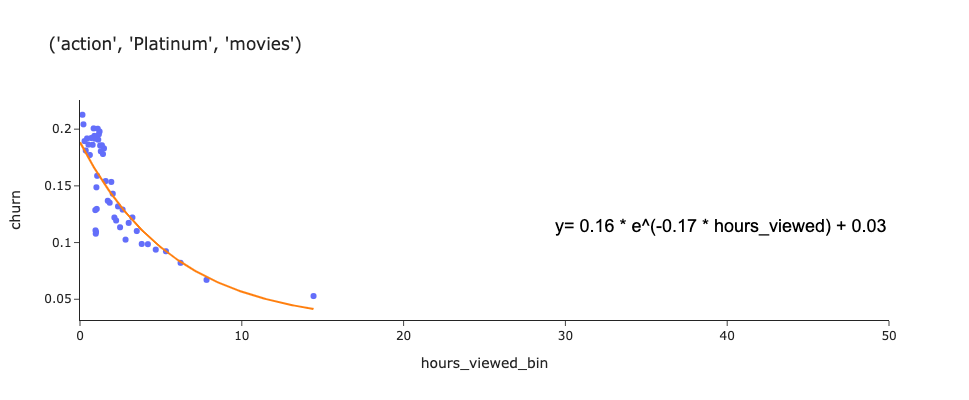

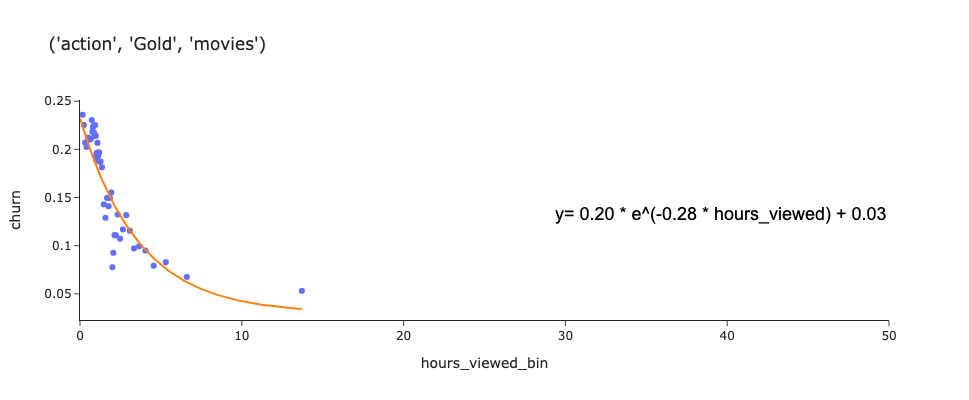

In [43]:
old_new = ['current','library']
genre = ['action']
medal = ['Platinum','Gold']
category = ['movies']
# acq = ['']
x_var = 'hours_viewed_bin'

param_dic = {}
# old_new = ['current','library']
# genre = ['action']
# medal = ['Silver']
# category = ['movies']


for g, m,c in list(itertools.product(genre, medal, category)): #old_new,
    df_fit = df_60[(df_60.genre==g) & (df_60.medal==m)& (df_60.content_category==c) &(df_60.tenure_months>=2)&(df_60.tenure_months<7)] ##  (df_plt.old_new==o) 
    
    if df_fit.empty:
        pass
    else:
        df_fit = get_churn_bin(df_fit, [])
        list_id = df_fit['hbo_uuid'].unique()

        df_zero = df_60[~df_60['hbo_uuid'].isin(list_id)]
        df_zero['hours_viewed_bin'] = 0
        df_zero['churn'] = 1*df_zero['is_cancel'] 
        df_zero = df_zero.groupby(by=['hours_viewed_bin']).agg({'churn':'mean', 'hbo_uuid':'count','is_cancel':'sum','monthly_hours_viewed':'sum'}).reset_index()

        df_i = pd.concat([df_zero, df_fit])
        df_i = df_i[df_i.is_cancel>=10]
#         display(df_i.tail(5))

        x_var = df_i.hours_viewed_bin
        y_data = df_i.churn
        p0 = [0.5, -0.1, 0.01] 
        param_bounds = ([0, -1, 0], [np.inf, -0.1, np.inf])
#         print(x_var, y_data)

        x_fit, params = fit_exponential(x_var, y_data, p0, param_bounds)
        a_fit, b_fit, c_fit = params

        y_fit = exponential_decay(x_fit, a_fit, b_fit, c_fit)
        get_simple_plot_multiple(df_fit, 'hours_viewed_bin', 'churn', x_fit, y_fit, params, f'{g, m, c}')
        param_dic[f'{g}_{m}_{c}'] = params

        del df_zero, df_fit, df_i
    
#     display(df_fit.head())  

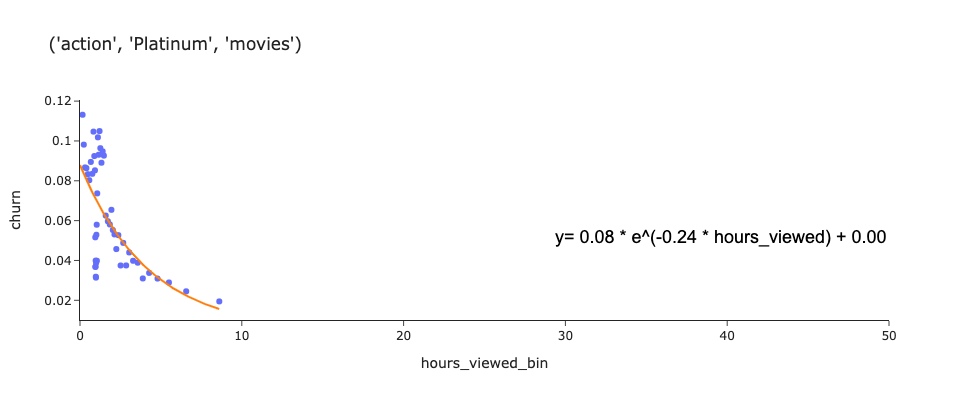

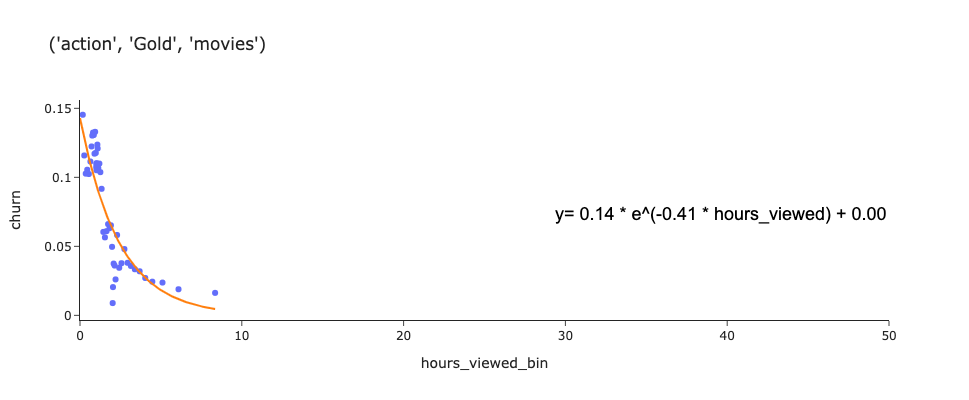

In [29]:
tenure >=2



In [34]:
df_pf = df_60[(df_60.genre=='action') & (df_60.medal=='Platinum')& (df_60.content_category=='movies')& (df_60.tenure_months==6)] ##  (df_plt.old_new==o) 
df_gf = df_60[(df_60.genre=='action') & (df_60.medal=='Gold')& (df_60.content_category=='movies')& (df_60.tenure_months==6)] ##  (df_plt.old_new==o) 

df_pf = df_pf.groupby(by=['hbo_uuid']+['is_cancel']).sum().reset_index()
df_gf = df_gf.groupby(by=['hbo_uuid']+['is_cancel']).sum().reset_index()

In [35]:
df_pft = df_pf[df_pf.monthly_hours_viewed<=0.193]
display(df_pft.describe())
# display(df_pft[df_pft.tenure_months==2].shape)
df_pft = df_pf[(df_pf.monthly_hours_viewed>0.193) & (df_pf.monthly_hours_viewed<=0.272)]
display(df_pft.describe())
# display(df_pft[df_pft.tenure_months==1].shape)
df_pft = df_pf[(df_pf.monthly_hours_viewed>0.272) & (df_pf.monthly_hours_viewed<=0.349)]
display(df_pft.describe())
# display(df_pft[df_pft.tenure_months==1].shape)

,index,Unnamed: 0,sub_month,hours_viewed,tenure_months,monthly_hours_viewed
count,1.123000e+03,1.123000e+03,1123.0,1123.000000,1123.0,1123.000000
mean,7.850790e+06,7.850790e+06,6.0,0.317223,6.0,0.158611
std,4.681295e+06,4.681295e+06,0.0,0.038957,0.0,0.019479
min,2.987500e+04,2.987500e+04,6.0,0.250000,6.0,0.125000
25%,3.926682e+06,3.926682e+06,6.0,0.283889,6.0,0.141944
50%,7.638297e+06,7.638297e+06,6.0,0.316944,6.0,0.158472
75%,1.164905e+07,1.164905e+07,6.0,0.350417,6.0,0.175208
max,1.703329e+07,1.703329e+07,6.0,0.385833,6.0,0.192917


,index,Unnamed: 0,sub_month,hours_viewed,tenure_months,monthly_hours_viewed
count,9.480000e+02,9.480000e+02,948.0,948.000000,948.0,948.000000
mean,8.066016e+06,8.066016e+06,6.0,0.463083,6.0,0.231542
std,4.613275e+06,4.613275e+06,0.0,0.045064,0.0,0.022532
min,5.875500e+04,5.875500e+04,6.0,0.386111,6.0,0.193056
25%,4.064585e+06,4.064585e+06,6.0,0.422500,6.0,0.211250
50%,8.051272e+06,8.051272e+06,6.0,0.463472,6.0,0.231736
75%,1.161539e+07,1.161539e+07,6.0,0.503056,6.0,0.251528
max,1.703244e+07,1.703244e+07,6.0,0.543889,6.0,0.271944


,index,Unnamed: 0,sub_month,hours_viewed,tenure_months,monthly_hours_viewed
count,8.370000e+02,8.370000e+02,837.000000,837.000000,837.000000,837.000000
mean,7.876896e+06,7.876896e+06,6.035842,0.622637,6.035842,0.311318
std,4.803789e+06,4.803789e+06,0.462628,0.043850,0.462628,0.021925
min,1.646100e+04,1.646100e+04,6.000000,0.544167,6.000000,0.272083
25%,3.585465e+06,3.585465e+06,6.000000,0.583611,6.000000,0.291806
50%,8.133097e+06,8.133097e+06,6.000000,0.623333,6.000000,0.311667
75%,1.168158e+07,1.168158e+07,6.000000,0.658889,6.000000,0.329444
max,2.877482e+07,2.877482e+07,12.000000,0.697500,12.000000,0.348750


In [36]:
df_pft = df_gf[df_gf.monthly_hours_viewed<=0.217]
display(df_pft.describe())
# display(df_pft[df_pft.tenure_months==2].shape)
df_pft = df_gf[(df_gf.monthly_hours_viewed>0.217) & (df_gf.monthly_hours_viewed<=0.309)]
display(df_pft.describe())
# display(df_pft[df_pft.tenure_months==1].shape)
df_pft = df_gf[(df_gf.monthly_hours_viewed>0.309) & (df_gf.monthly_hours_viewed<=0.398)]
display(df_pft.describe())
# display(df_pft[df_pft.tenure_months==1].shape)

,index,Unnamed: 0,sub_month,hours_viewed,tenure_months,monthly_hours_viewed
count,1.295000e+03,1.295000e+03,1295.0,1295.000000,1295.0,1295.000000
mean,8.275458e+06,8.275458e+06,6.0,0.341470,6.0,0.170735
std,4.735920e+06,4.735920e+06,0.0,0.053296,0.0,0.026648
min,1.824200e+04,1.824200e+04,6.0,0.250000,6.0,0.125000
25%,4.351180e+06,4.351180e+06,6.0,0.295278,6.0,0.147639
50%,8.147464e+06,8.147464e+06,6.0,0.340556,6.0,0.170278
75%,1.200365e+07,1.200365e+07,6.0,0.387083,6.0,0.193542
max,1.698205e+07,1.698205e+07,6.0,0.433889,6.0,0.216944


,index,Unnamed: 0,sub_month,hours_viewed,tenure_months,monthly_hours_viewed
count,1.022000e+03,1.022000e+03,1022.000000,1022.000000,1022.000000,1022.000000
mean,7.971643e+06,7.971643e+06,6.023483,0.526770,6.023483,0.263385
std,4.879763e+06,4.879763e+06,0.374815,0.050816,0.374815,0.025408
min,6.369300e+04,6.369300e+04,6.000000,0.434722,6.000000,0.217361
25%,3.977781e+06,3.977781e+06,6.000000,0.485556,6.000000,0.242778
50%,7.599808e+06,7.599808e+06,6.000000,0.527222,6.000000,0.263611
75%,1.179409e+07,1.179409e+07,6.000000,0.566042,6.000000,0.283021
max,2.462676e+07,2.462676e+07,12.000000,0.617778,12.000000,0.308889


,index,Unnamed: 0,sub_month,hours_viewed,tenure_months,monthly_hours_viewed
count,9.830000e+02,9.830000e+02,983.000000,983.000000,983.000000,983.000000
mean,8.224022e+06,8.224022e+06,6.073245,0.704663,6.073245,0.352331
std,5.021527e+06,5.021527e+06,0.659203,0.051587,0.659203,0.025794
min,7.571000e+03,7.571000e+03,6.000000,0.618056,6.000000,0.309028
25%,3.567716e+06,3.567716e+06,6.000000,0.660556,6.000000,0.330278
50%,8.368858e+06,8.368858e+06,6.000000,0.700278,6.000000,0.350139
75%,1.219137e+07,1.219137e+07,6.000000,0.750417,6.000000,0.375208
max,3.225431e+07,3.225431e+07,12.000000,0.795833,12.000000,0.397917


,index,Unnamed: 0,sub_month,hours_viewed,tenure_months,monthly_hours_viewed
count,1.549900e+04,1.549900e+04,15499.000000,15499.000000,15499.000000,15499.000000
mean,7.533316e+06,7.533316e+06,15.135622,0.317176,15.135622,0.158588
std,4.497190e+06,4.497190e+06,8.149790,0.038943,8.149790,0.019471
min,5.207000e+03,5.207000e+03,3.000000,0.250000,3.000000,0.125000
25%,3.732508e+06,3.732508e+06,8.000000,0.283889,8.000000,0.141944
50%,7.391442e+06,7.391442e+06,15.000000,0.316667,15.000000,0.158333
75%,1.102220e+07,1.102220e+07,22.000000,0.351111,22.000000,0.175556
max,1.705620e+07,1.705620e+07,50.000000,0.385833,50.000000,0.192917


,index,Unnamed: 0,sub_month,hours_viewed,tenure_months,monthly_hours_viewed
count,1.585400e+04,1.585400e+04,15854.000000,15854.000000,15854.000000,15854.000000
mean,7.914371e+06,7.914371e+06,16.381923,0.465609,16.381923,0.232804
std,4.974972e+06,4.974972e+06,9.494338,0.045600,9.494338,0.022800
min,1.877000e+03,1.877000e+03,3.000000,0.386111,3.000000,0.193056
25%,3.888313e+06,3.888313e+06,9.000000,0.425347,9.000000,0.212674
50%,7.591978e+06,7.591978e+06,16.000000,0.465556,16.000000,0.232778
75%,1.134091e+07,1.134091e+07,22.000000,0.505278,22.000000,0.252639
max,3.210822e+07,3.210822e+07,59.000000,0.543889,59.000000,0.271944


,index,Unnamed: 0,sub_month,hours_viewed,tenure_months,monthly_hours_viewed
count,1.558200e+04,1.558200e+04,15582.000000,15582.000000,15582.000000,15582.000000
mean,8.939082e+06,8.939082e+06,18.273457,0.619854,18.273457,0.309927
std,5.949499e+06,5.949499e+06,11.540070,0.043811,11.540070,0.021906
min,4.057000e+03,4.057000e+03,3.000000,0.544167,3.000000,0.272083
25%,4.279860e+06,4.279860e+06,10.000000,0.582500,10.000000,0.291250
50%,8.238568e+06,8.238568e+06,18.000000,0.618611,18.000000,0.309306
75%,1.220565e+07,1.220565e+07,24.000000,0.657222,24.000000,0.328611
max,3.349594e+07,3.349594e+07,61.000000,0.697778,61.000000,0.348889


,index,Unnamed: 0,sub_month,hours_viewed,tenure_months,monthly_hours_viewed
count,1.547500e+04,1.547500e+04,15475.000000,15475.000000,15475.000000,15475.000000
mean,8.047834e+06,8.047834e+06,14.483489,0.339766,14.483489,0.169883
std,4.726633e+06,4.726633e+06,7.962415,0.053037,7.962415,0.026518
min,2.611000e+03,2.611000e+03,3.000000,0.250000,3.000000,0.125000
25%,3.974902e+06,3.974902e+06,8.000000,0.294306,8.000000,0.147153
50%,7.935304e+06,7.935304e+06,14.000000,0.338056,14.000000,0.169028
75%,1.184525e+07,1.184525e+07,21.000000,0.385000,21.000000,0.192500
max,1.706323e+07,1.706323e+07,50.000000,0.433889,50.000000,0.216944


,index,Unnamed: 0,sub_month,hours_viewed,tenure_months,monthly_hours_viewed
count,1.563000e+04,1.563000e+04,15630.000000,15630.000000,15630.000000,15630.000000
mean,9.596127e+06,9.596127e+06,17.926679,0.532226,17.926679,0.266113
std,6.137639e+06,6.137639e+06,11.968275,0.050809,11.968275,0.025404
min,2.265000e+03,2.265000e+03,3.000000,0.434167,3.000000,0.217083
25%,4.724912e+06,4.724912e+06,9.000000,0.493056,9.000000,0.246528
50%,9.195904e+06,9.195904e+06,17.000000,0.534722,17.000000,0.267361
75%,1.354788e+07,1.354788e+07,23.000000,0.574444,23.000000,0.287222
max,3.371359e+07,3.371359e+07,79.000000,0.617778,79.000000,0.308889


,index,Unnamed: 0,sub_month,hours_viewed,tenure_months,monthly_hours_viewed
count,1.567300e+04,1.567300e+04,15673.000000,15673.000000,15673.000000,15673.000000
mean,1.028062e+07,1.028062e+07,19.582339,0.705154,19.582339,0.352577
std,6.576640e+06,6.576640e+06,13.381248,0.051361,13.381248,0.025680
min,1.389200e+04,1.389200e+04,3.000000,0.618056,3.000000,0.309028
25%,5.008826e+06,5.008826e+06,10.000000,0.661389,10.000000,0.330694
50%,9.749911e+06,9.749911e+06,18.000000,0.702778,18.000000,0.351389
75%,1.440578e+07,1.440578e+07,26.000000,0.749722,26.000000,0.374861
max,3.691507e+07,3.691507e+07,87.000000,0.795833,87.000000,0.397917


In [11]:
display(df_p.head())
display(df_g.head())

,hours_viewed_bin,churn,hbo_uuid,is_cancel,monthly_hours_viewed
0,0.1585,0.129185,17146,2215,2719.537778
1,0.2325,0.112638,17099,1926,3982.092222
2,0.3105,0.099521,17132,1705,5312.835417
3,0.3930,0.099953,17118,1711,6727.471944
4,0.4810,0.096184,17113,1646,8226.780278


,hours_viewed_bin,churn,hbo_uuid,is_cancel,monthly_hours_viewed
0,0.1705,0.161711,17185,2779,2921.650139
1,0.2630,0.132902,17163,2281,4570.002639
2,0.3535,0.115988,17157,1990,6052.216250
3,0.4475,0.121325,17177,2084,7676.089861
4,0.5475,0.118065,17177,2028,9398.617222


## Hours_view distribution


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


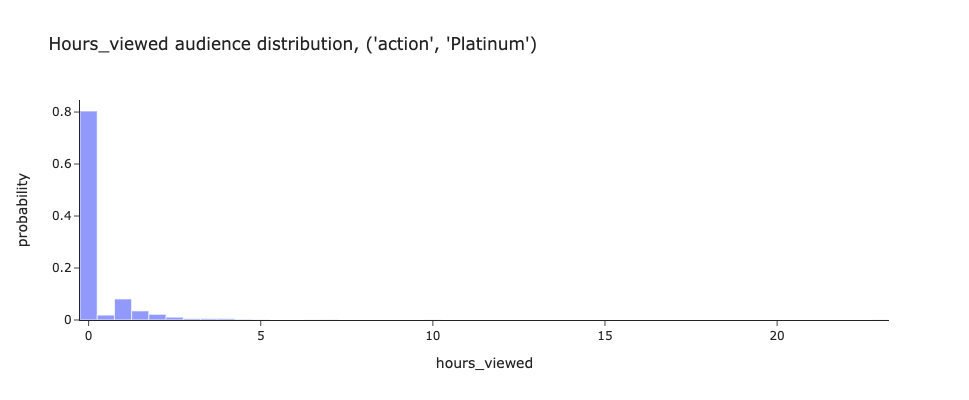


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


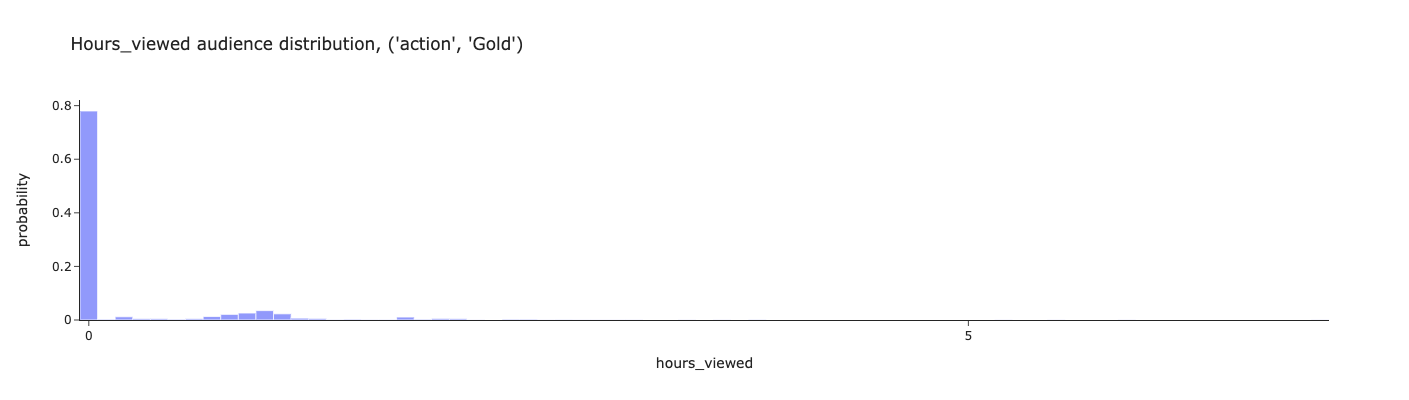


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


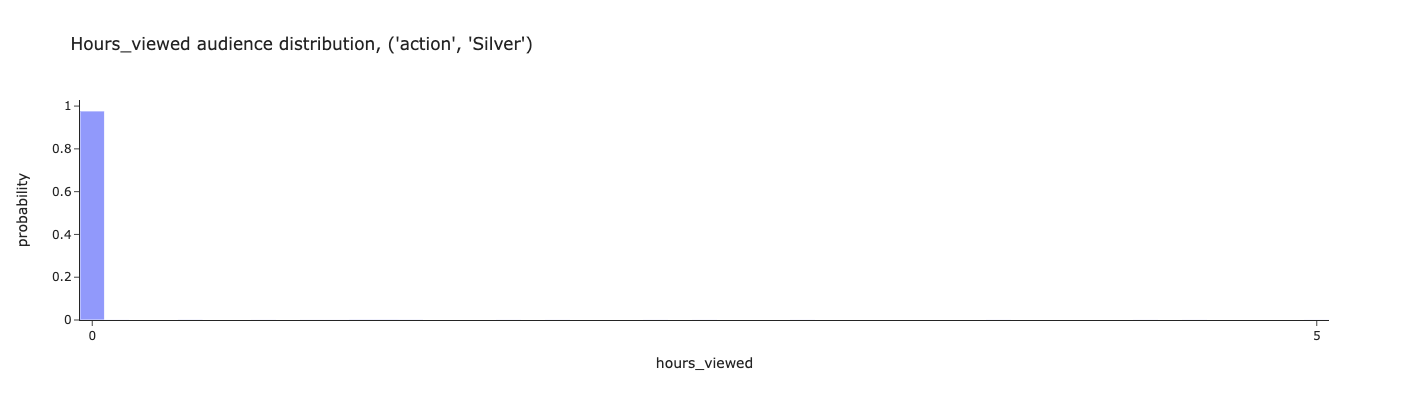


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


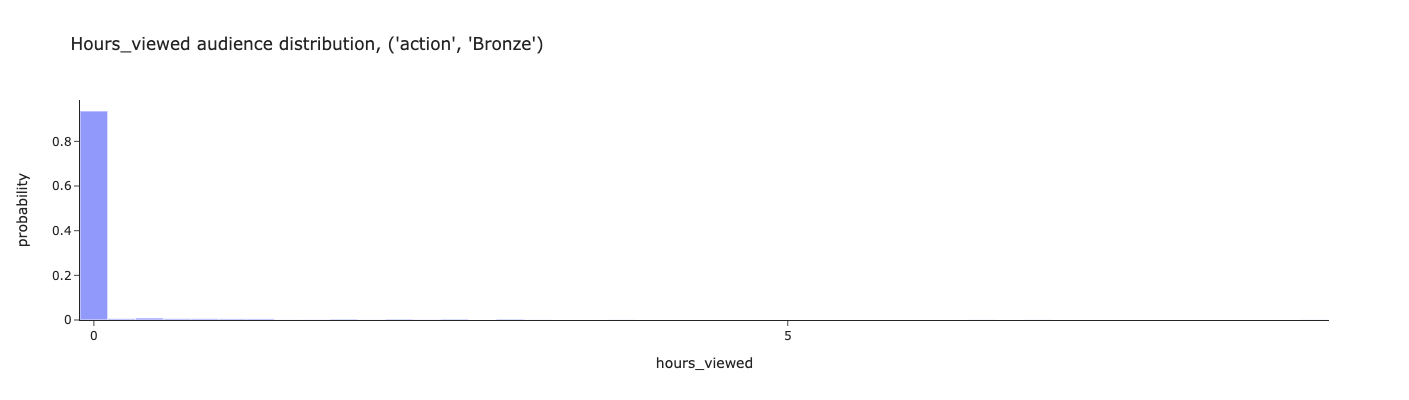

In [22]:
def get_histogram(df_plt, x, title='', histnorm='probability'):
    if title=='':
        title = f'{x}'
    fig = px.histogram(df_plt, x=x,
                  title=title, 
                  width=600, height=400, opacity=0.7, histnorm='probability', nbins=80)
    fig.update_layout(showlegend=False, 
                      xaxis_title_text = 'hours_viewed',
                      barmode='overlay', 
                      xaxis=dict(dtick=5),
                      template='simple_white',)
    fig.show()
    return 


for g, m in list(itertools.product(genre, medal)): #old_new,
    df_fit = df_60[(df_60.genre==g) & (df_60.medal==m)] ##  (df_plt.old_new==o) 
    df_fit = df_fit[(df_fit.monthly_hours_viewed<=80)].groupby(['hbo_uuid','sub_month']).sum().reset_index()
    
    list_id = df_fit['hbo_uuid'].unique()
    df_zero = df_60[~df_60['hbo_uuid'].isin(list_id)]
    df_zero['monthly_hours_viewed'] = 0
    df_zero = df_zero.groupby(['hbo_uuid','sub_month']).sum().reset_index()

    df_i= pd.concat([df_zero, df_fit])
    get_histogram(df_i[df_i.monthly_hours_viewed<=80].sample(n=1000), 'monthly_hours_viewed', f'Hours_viewed audience distribution, {g,m}')


## Get weighted average retention value

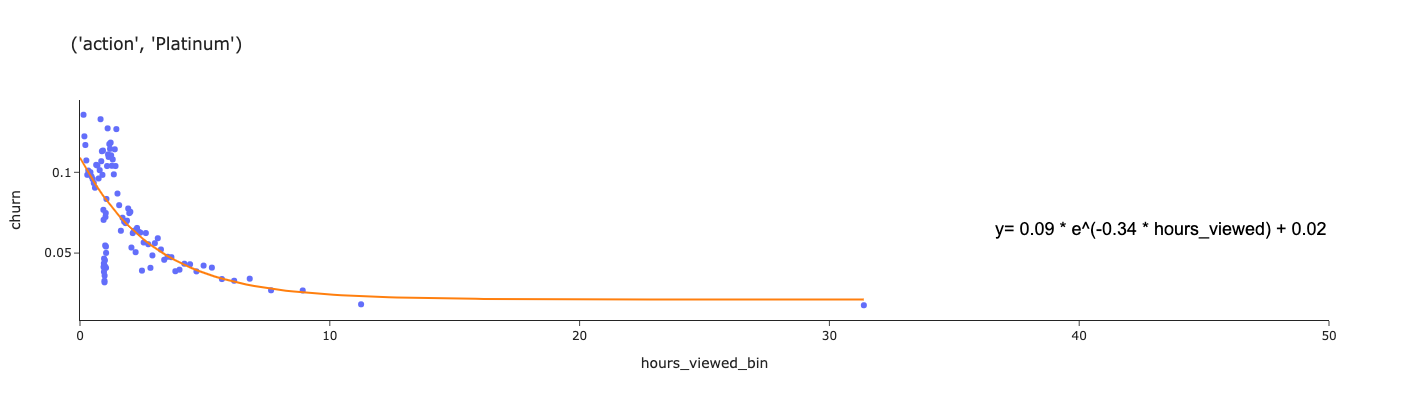

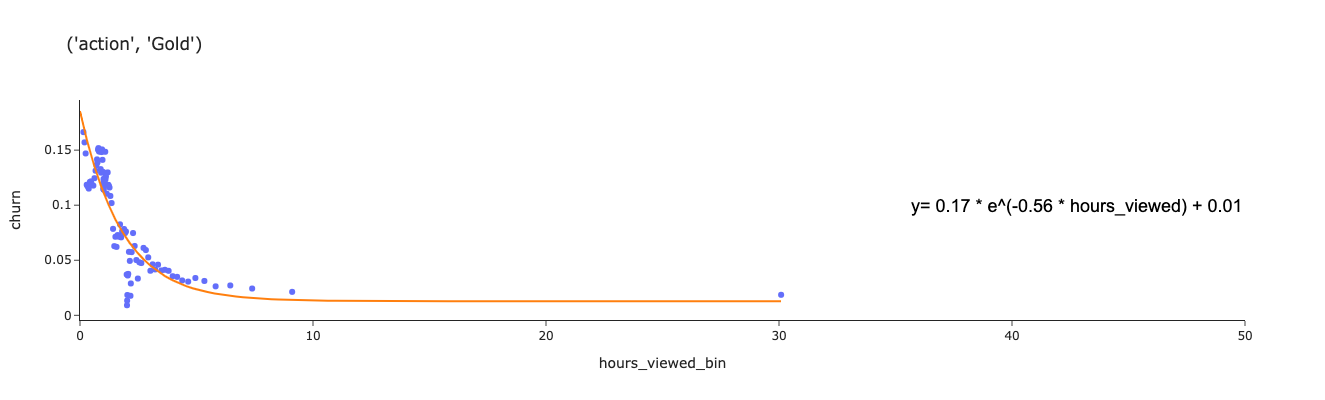

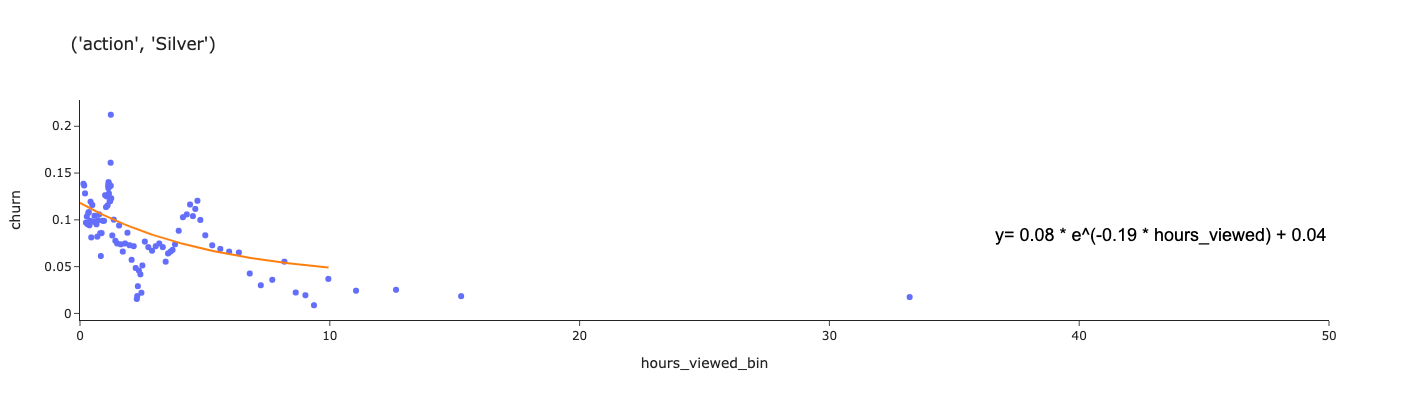

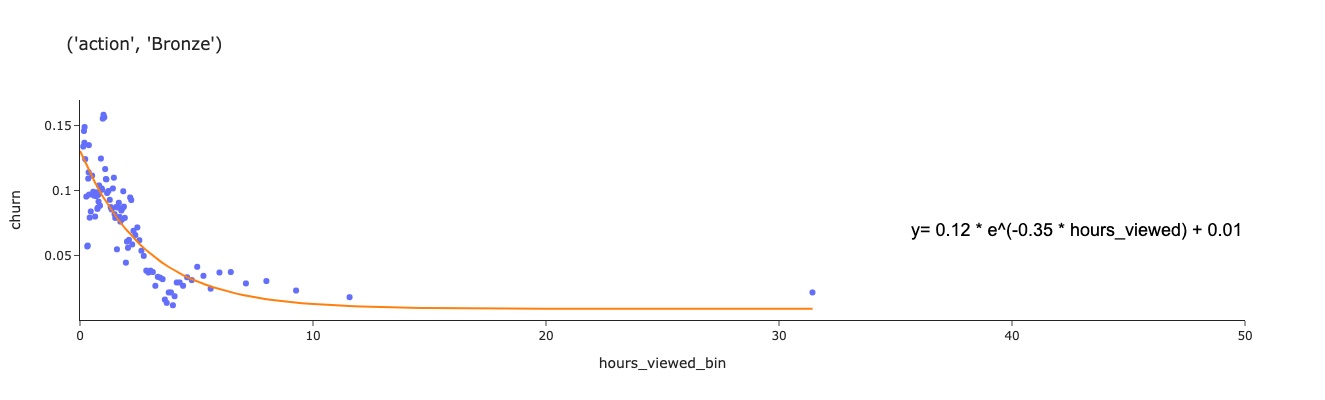


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,hours_viewed,probability,slope,weighted_slope
0,0.5,4.112304e-01,3.508754e-02,0.014429
1,1.5,3.853068e-01,4.918207e-02,0.018950
2,2.5,1.112436e-01,6.893833e-02,0.007669
3,3.5,4.355154e-02,9.663060e-02,0.004208
4,4.5,2.035709e-02,1.354468e-01,0.002757
5,5.5,1.045744e-02,1.898552e-01,0.001985
6,6.5,5.888616e-03,2.661194e-01,0.001567
7,7.5,3.494423e-03,3.730185e-01,0.001303
8,8.5,2.228714e-03,5.228587e-01,0.001165
9,9.5,1.460248e-03,7.328891e-01,0.001070



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,hours_viewed,probability,slope,weighted_slope
1,0.5,4.089458e-01,1.266294e-01,5.178459e-02
0,1.5,4.432862e-01,2.206662e-01,9.781829e-02
2,2.5,9.099364e-02,3.845360e-01,3.499033e-02
3,3.5,3.055240e-02,6.700977e-01,2.047309e-02
4,4.5,1.215438e-02,1.167721e+00,1.419293e-02
5,5.5,5.853914e-03,2.034887e+00,1.191206e-02
6,6.5,3.001875e-03,3.546023e+00,1.064472e-02
7,7.5,1.637856e-03,6.179348e+00,1.012088e-02
8,8.5,1.033348e-03,1.076822e+01,1.112731e-02
9,9.5,6.377231e-04,1.876484e+01,1.196677e-02


In [21]:
# def get_churn_bin(df_in, grpby):
#     df = df_in.groupby(by=['hbo_uuid']+ grpby +['is_cancel']).sum().reset_index()
#     df = df[df.monthly_hours_viewed<=50]
#     nbins = 100
#     df['hours_viewed_bin'] = pd.qcut(df['monthly_hours_viewed'], np.linspace(0,1,nbins), duplicates='drop')
#     df['hours_viewed_bin'] = df['hours_viewed_bin'].apply(lambda x: (x.left+x.right)/2)
#     df['hours_viewed_bin'] = df['hours_viewed_bin'].astype('float')
#     df['churn'] = 1*df['is_cancel']  
    
# #     df=df[df.ttl_stream_hrs_bin<=300]S
#     df_bin = df.groupby(grpby+['hours_viewed_bin']).agg({'churn':'mean', 'hbo_uuid':'count','is_cancel':'sum','monthly_hours_viewed':'sum'}).reset_index()
    
#     return(df_bin)


# old_new = ['current','library']
# genre = ['action','comedy','drama','other']
# medal = ['Platinum','Gold','Silver','Bronze']
# category = ['series','movies']
# x_var = 'hours_viewed_bin'

# param_dic = {}

# for g, m, c in list(itertools.product(genre, medal, category)): #old_new,
#     df_fit = df_60[(df_60.genre==g) & (df_60.medal==m)] ##  (df_plt.old_new==o) 
#     df_fit = get_churn_bin(df_fit, [])
#     list_id = df_fit['hbo_uuid'].unique()
    
#     df_zero = df_60[~df_60['hbo_uuid'].isin(list_id)]
#     df_zero['hours_viewed_bin'] = 0
#     df_zero['churn'] = 1*df_zero['is_cancel'] 
#     df_zero = df_zero.groupby(by=['hours_viewed_bin']).agg({'churn':'mean', 'hbo_uuid':'count','is_cancel':'sum','monthly_hours_viewed':'sum'}).reset_index()

#     df_i = pd.concat([df_zero, df_fit])
#     df_i = pd.concat([df_fit])
#     df_i = df_i[df_i.is_cancel>=10]

#     x_var = df_i.hours_viewed_bin
#     y_data = df_i.churn
#     p0 = [0.5, 0.5, 0.1] 
#     param_bounds = ([0, -np.inf, 0], [np.inf, 1, np.inf])

#     x_fit, params = fit_exponential(x_var, y_data, p0, param_bounds)
#     a_fit, b_fit, c_fit = params
    
#     y_fit = exponential_decay(x_fit, a_fit, b_fit, c_fit)
#     get_simple_plot_multiple(df_fit, 'hours_viewed_bin', 'churn', x_fit, y_fit, params, f'{g, m}')
#     param_dic[f'{g}_{m}'] = params
    
#     del df_fit, df_i


# genre_list=[]
# medal_list=[]
# churn_per_hr_viewed_person_list = []

# for g, m, c in list(itertools.product(['action'], medal)): #old_new,
#     ## Get hours_viewed raw data 
# #     print(g,m)
#     df_fit = df_60[(df_60.genre==g) & (df_60.medal==m)] ##  (df_plt.old_new==o) 
#     df_fit = df_fit[(df_fit.monthly_hours_viewed<=80)].groupby(['hbo_uuid','sub_month']).sum().reset_index()

#     list_id = df_fit['hbo_uuid'].unique()
#     df_zero = df_60[~df_60['hbo_uuid'].isin(list_id)]
#     df_zero['monthly_hours_viewed'] = 0
#     df_zero = df_zero.groupby(['hbo_uuid','sub_month']).sum().reset_index()
#     df_i= pd.concat([df_zero, df_fit])

#     ## Bin and get distribution
#     bins = pd.cut(df_i['monthly_hours_viewed'], np.linspace(0,80,81))
#     df_p = bins.value_counts(normalize=True).reset_index()
#     df_p.columns = ['hours_viewed', 'probability']
#     df_p['hours_viewed'] = df_p['hours_viewed'].apply(lambda x: (x.left+x.right)/2)
#     df_p.hours_viewed = df_p.hours_viewed.astype(float)
#     df_p = df_p.sort_values(by='hours_viewed', ascending=True)

#     # Apply curve params
#     a, b, c = param_dic[f'{g}_{m}']
#     df_p['slope'] = -a*b * np.exp(-b*df_p.hours_viewed)
#     df_p['weighted_slope'] = df_p['slope'] * df_p['probability']

#     churn_metric = df_p['weighted_slope'].sum()
#     genre_list.append(g)
#     medal_list.append(m)
#     churn_per_hr_viewed_person_list.append(churn_metric)
    
#     display(df_p)
    
# #     del df_zero, df_fit

In [8]:
## Calculating weighted mean of hours_viewed

## Define final dataframe 
genre = ['action','comedy','drama','other']
medal = ['Platinum','Gold','Silver','Bronze']
category = ['series','movies']

genre_list=[]
medal_list=[]
category_list=[]
churn_per_hr_viewed_person_list = []

for g, m, c in list(itertools.product(genre, medal, category)): #old_new,
    try:
        a, b, d = param_dic[f'{g}_{m}_{c}']
    except:
        pass 
    
    ## Get hours_viewed raw data 
    print(g,m,c)
    df_fit = df_60[(df_60.genre==g) & (df_60.medal==m) & (df_60.content_category==c)] ##  (df_plt.old_new==o) 
    df_fit = df_fit[(df_fit.monthly_hours_viewed<=80)].groupby(['hbo_uuid','sub_month']).sum().reset_index()

    list_id = df_fit['hbo_uuid'].unique()
    df_zero = df_60[~df_60['hbo_uuid'].isin(list_id)]
    df_zero['monthly_hours_viewed'] = 0
    df_zero = df_zero.groupby(['hbo_uuid','sub_month']).sum().reset_index()
    df_i= pd.concat([df_zero, df_fit])

    ## Bin and get distribution
    bins = pd.cut(df_i['monthly_hours_viewed'], np.linspace(0,80,81))
    df_p = bins.value_counts(normalize=True).reset_index()
    df_p.columns = ['hours_viewed', 'probability']
    df_p['hours_viewed'] = df_p['hours_viewed'].apply(lambda x: (x.left+x.right)/2)
    df_p.hours_viewed = df_p.hours_viewed.astype(float)
    df_p = df_p.sort_values(by='hours_viewed', ascending=True)

    # Apply curve params
    df_p['slope'] = a*b * np.exp(b*df_p.hours_viewed)
    df_p['weighted_slope'] = df_p['slope'] * df_p['probability']

    churn_metric = df_p['weighted_slope'].sum()
    genre_list.append(g)
    medal_list.append(m)
    category_list.append(c)
    churn_per_hr_viewed_person_list.append(churn_metric)


    del df_zero, df_fit

    
df_retention = pd.DataFrame({'genre': genre_list, 
                   'medal': medal_list, 
                    'category': category_list, 
                   'churn_per_hr_person':churn_per_hr_viewed_person_list})

df_retention

# input_bucket="hbo-ingest-datascience-content-dev"
# key_path = 'cost_allocation/dev'

# Utils.to_csv_s3(df_retention, input_bucket, key_path, 'churn_metric_0824.csv')
# Utils.to_csv_s3(df_p, input_bucket, key_path, 'churn_metric_df_p_0824.csv')

action Platinum series
action Platinum movies



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


action Gold series
action Gold movies



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


action Silver series



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


action Silver movies



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


action Bronze series



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


action Bronze movies



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


comedy Platinum series



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


comedy Platinum movies
comedy Gold series



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


comedy Gold movies



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


comedy Silver series



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


comedy Silver movies



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


comedy Bronze series



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


comedy Bronze movies



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


drama Platinum series



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


drama Platinum movies



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


drama Gold series



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


drama Gold movies



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


drama Silver series



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


drama Silver movies



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


drama Bronze series



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


drama Bronze movies



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


other Platinum series
other Platinum movies



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


other Gold series



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


other Gold movies



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


other Silver series



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


other Silver movies



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


other Bronze series



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


other Bronze movies



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,genre,medal,category,churn_per_hr_person
0,action,Platinum,series,0.000000e+00
1,action,Platinum,movies,-1.455308e-02
2,action,Gold,series,0.000000e+00
3,action,Gold,movies,-3.779967e-02
4,action,Silver,series,-5.618291e-03
5,action,Silver,movies,-3.425482e-02
6,action,Bronze,series,-2.000112e-02
7,action,Bronze,movies,-3.302375e-02
8,comedy,Platinum,series,-1.078319e-02
9,comedy,Platinum,movies,0.000000e+00


In [9]:
display(param_dic)   

{'action_Platinum_movies': array([ 0.09183169, -0.21083878,  0.00740399]),
 'action_Gold_movies': array([ 1.57003452e-01, -3.78077140e-01,  3.06045180e-07]),
 'action_Silver_series': array([ 0.07162914, -0.1       ,  0.02606626]),
 'action_Silver_movies': array([ 1.55536205e-01, -3.27217081e-01,  2.80500355e-19]),
 'action_Bronze_series': array([ 1.13873254e-01, -2.47554423e-01,  2.54561949e-22]),
 'action_Bronze_movies': array([ 1.67409912e-01, -2.39600034e-01,  4.10184538e-15]),
 'comedy_Platinum_series': array([ 1.02261196e-01, -1.32790177e-01,  7.73434647e-19]),
 'comedy_Gold_series': array([ 7.77095008e-02, -1.62712384e-01,  1.70732898e-14]),
 'comedy_Gold_movies': array([ 8.59423785e-02, -5.81989592e-01,  2.48025151e-19]),
 'comedy_Silver_series': array([ 7.90154223e-02, -2.25272655e-01,  4.81627069e-05]),
 'comedy_Silver_movies': array([ 1.49646395e-11, -1.00000000e-01,  9.39942310e-02]),
 'comedy_Bronze_series': array([ 1.17231078e-01, -3.94354121e-01,  6.72730483e-24]),
 'come

In [5]:
df_retention = Utils.read_csv_s3(input_bucket, key_path, 'churn_metric_0824.csv')
df_retention.sort_values(by=['category','genre','medal'])

Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
INFO:root:Read from hbo-ingest-datascience-content-dev/cost_allocation/dev/churn_metric_0824.csv


,Unnamed: 0,genre,medal,category,churn_per_hr_person
7,7,action,Bronze,movies,-3.302375e-02
3,3,action,Gold,movies,-3.779967e-02
1,1,action,Platinum,movies,-1.455308e-02
5,5,action,Silver,movies,-3.425482e-02
15,15,comedy,Bronze,movies,-4.281132e-03
11,11,comedy,Gold,movies,-3.434493e-02
9,9,comedy,Platinum,movies,0.000000e+00
13,13,comedy,Silver,movies,-1.413461e-12
23,23,drama,Bronze,movies,-3.470291e-02
19,19,drama,Gold,movies,-5.309591e-02


In [6]:
df_hv_decay.merge(df_retention, on=['genre','medal',''])

,title_name,title_id,season_number,genre,medal,offering_start_date,request_date,days_on_hbo_max,change_in_churn,date_month,prediction
0,AVPR Aliens vs. Predator Requiem,GV-BGQgVr57OCwgEAAAAp,0,action,Bronze,2020-09-01,2020-09-01,0,-0.000009,2020-09,NaN
1,AVPR Aliens vs. Predator Requiem,GV-BGQgVr57OCwgEAAAAp,0,action,Bronze,2020-09-01,2020-09-02,1,-0.000009,2020-09,NaN
2,AVPR Aliens vs. Predator Requiem,GV-BGQgVr57OCwgEAAAAp,0,action,Bronze,2020-09-01,2020-09-03,2,-0.000009,2020-09,NaN
3,AVPR Aliens vs. Predator Requiem,GV-BGQgVr57OCwgEAAAAp,0,action,Bronze,2020-09-01,2020-09-04,3,-0.000009,2020-09,NaN
4,AVPR Aliens vs. Predator Requiem,GV-BGQgVr57OCwgEAAAAp,0,action,Bronze,2020-09-01,2020-09-05,4,-0.000009,2020-09,NaN
...,...,...,...,...,...,...,...,...,...,...,...
452077,Injustice,GYbvoqgoeYawYwwEAAAAN,0,action,Bronze,2022-01-17,2023-02-25,404,-0.000091,2023-02,0.073452
452078,Injustice,GYbvoqgoeYawYwwEAAAAN,0,action,Bronze,2022-01-17,2023-02-26,405,-0.000091,2023-02,0.073452
452079,Injustice,GYbvoqgoeYawYwwEAAAAN,0,action,Bronze,2022-01-17,2023-02-27,406,-0.000091,2023-02,0.073452
452080,Injustice,GYbvoqgoeYawYwwEAAAAN,0,action,Bronze,2022-01-17,2023-02-28,407,-0.000091,2023-02,0.073452


In [ ]:
# comedy series, other movie (gold&bronze > plat), drama movie (gold&bronze > platinum), action movie (>plat)
# churn high in low hours watched for lower medals. why? 
### correlated with tenure? 
### 

## Medal- genre curve, fitting to one- didn't work

In [50]:
## Build curve for medal & genre, put weight 
def resample_data(df_sample, grpby):  
    ## Loop through old and recent data
    df_resample_list = []
    max_count = df_sample.groupby(by=grpby)['hbo_uuid'].max().reset_index()
    min_value= max_count.hbo_uuid.min()
    max_count['weight'] = max_count['hbo_uuid']/min_value
    max_count['weight'] = max_count['weight'].astype(int)
    
    df_sample = df_sample.merge(max_count[grpby+['weight']], on=grpby, how='left')
    print(df_sample.shape)
    df_sample = df_sample.loc[df_sample.index.repeat(df_sample['weight'])]
    print(df_sample.shape)
    return df_sample
 
def get_simple_plot_multiple(df_plt, x, y, x_fit, y_fit, params, title=''):
#     if title=='':
        
#         title = f'{y} vs {x}'
       
# #     a_fit, b_fit, c_fit = params
#     annotation_x_loc = x_fit.max()
#     annotation_y_loc = y_fit.min() +(y_fit.max()  - y_fit.min() )/2 
        
    fig = px.scatter(df_plt,
                  x=x, 
                  y=y, 
                  title=title,
                  width=600, height=400)
    fig.add_scatter( 
              x=x_fit, 
              y=y_fit)

#     fig.update_layout(
#         template='simple_white',
#         showlegend=True,
#         xaxis=dict(range=[0,80]),
#         annotations=[
#         dict(
# #             x=annotation_x_loc,  # x-coordinate for the text
# #             y=annotation_y_loc,  # y-coordinate for the text
# #             text='y= {:.2f} * e^(-{:.2f} * hours_viewed) + {:.2f}'.format(a_fit, b_fit, c_fit),  # the text to display
# #             showarrow=False,  # disable arrow for the annotation
#             xanchor='right',
#             font=dict(
#                 family='Arial',  # specify font family
#                 size=18,  # specify font size
#                 color='black'  # specify font color
#             )
#         )
#     ]
# ) 
#     fig.show()
    return 


In [51]:
def get_dummies(df_in, features):
    for f in features:
        df_f = pd.get_dummies(df_in[f])
        df_in = pd.concat([df_in, df_f], axis=1)
    df_in.columns = df_in.columns.str.lower()
    
    return df_in

def exponential_multi(x, a, b1, b2, b3, b4, b5, b6, c):
    x1, x2, x3, x4, x5, x6 = x
    return a * np.exp(-(b1 * x1 +  b2 * x2 + b3 * x3 + b4*x4 + b5*x5 + b6*x6 )) + c


def fit_exponential_multi(x_var, y_data):
    params, _ = curve_fit(exponential_multi, x_var, y_data)
    print(params)
    
    return x_var,params

In [29]:
df_plt = df_60.copy()
df_plt['genre'] = np.where(~df_plt.genre.isin(['action','comedy','drama']), 'other', df_plt.genre)


# slice by content metadata 
grpby = ['medal','genre']

mask = (df_plt.program_type!=0) & (df_plt.tenure_months>=2)
df_fit = df_plt[mask]
df_i = get_churn_bin(df_fit, grpby)
df_i = resample_data(df_i, grpby)
df_i = get_dummies(df_i, grpby)
df_i = df_i[df_i.is_cancel>=30]

display(df_i.head())
display(df_i.describe(percentiles=[0.1,0.25,0.5,0.75,0.9]))


(380, 8)
(3648, 8)


,medal,genre,hours_viewed_bin,churn,hbo_uuid,is_cancel,monthly_hours_viewed,weight,NaN,bronze,gold,platinum,silver,action,comedy,drama,other
0,0,action,0.1905,0.059401,56952,3383,10410.853611,17,1,0,0,0,0,1,0,0,0
0,0,action,0.1905,0.059401,56952,3383,10410.853611,17,1,0,0,0,0,1,0,0,0
0,0,action,0.1905,0.059401,56952,3383,10410.853611,17,1,0,0,0,0,1,0,0,0
0,0,action,0.1905,0.059401,56952,3383,10410.853611,17,1,0,0,0,0,1,0,0,0
0,0,action,0.1905,0.059401,56952,3383,10410.853611,17,1,0,0,0,0,1,0,0,0


,hours_viewed_bin,churn,hbo_uuid,is_cancel,monthly_hours_viewed,weight,NaN,bronze,gold,platinum,silver,action,comedy,drama,other
count,3648.000000,3648.000000,3648.000000,3648.000000,3.648000e+03,3648.000000,3648.000000,3648.000000,3648.000000,3648.000000,3648.000000,3648.000000,3648.000000,3648.000000,3648.000000
mean,5.343263,0.050883,50745.428728,2580.787281,2.534614e+05,16.864583,0.427083,0.072917,0.276042,0.156250,0.067708,0.213542,0.208333,0.328125,0.250000
std,12.503140,0.009092,43271.521546,2204.742633,9.368881e+05,8.070622,0.494722,0.260035,0.447099,0.363142,0.251279,0.409863,0.406172,0.469595,0.433072
min,0.190500,0.000000,9.000000,0.000000,2.263438e+02,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10%,0.341500,0.036471,4989.100000,257.000000,8.985414e+03,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.792500,0.047714,19500.000000,829.000000,1.800748e+04,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.564500,0.051788,51285.000000,2349.000000,4.225335e+04,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.799000,0.056328,68029.000000,3370.000000,1.329573e+05,25.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.250000
90%,11.087000,0.060515,93844.000000,4821.000000,4.116986e+05,28.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,57.235500,0.101010,238419.000000,11615.000000,7.603804e+06,28.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


,medal,genre,hours_viewed_bin,churn,hbo_uuid,is_cancel,monthly_hours_viewed,weight,NaN,bronze,gold,platinum,silver,action,comedy,drama,other
0,0,action,0.1905,0.059401,56952,3383,10410.853611,17,1,0,0,0,0,1,0,0,0
0,0,action,0.1905,0.059401,56952,3383,10410.853611,17,1,0,0,0,0,1,0,0,0
0,0,action,0.1905,0.059401,56952,3383,10410.853611,17,1,0,0,0,0,1,0,0,0
0,0,action,0.1905,0.059401,56952,3383,10410.853611,17,1,0,0,0,0,1,0,0,0
0,0,action,0.1905,0.059401,56952,3383,10410.853611,17,1,0,0,0,0,1,0,0,0


In [ ]:

features= ['hours_viewed_bin','platinum','gold','action','comedy','drama']
x_var = [df_i[f] for f in features]
y_data = df_i.churn
p0 = [0.1, 0.5, 0.1]#,0.1]

x1_fit, params = fit_exponential_multi(x_var, y_data)
a, b1, b2, b3, b4, b5, b6, c = params